# Error Analysis
[for ConditionalQA baseline using FiD]

*choice of subset*: the **development** set

Note: remember to copy-paste the *evaluate.py* script under this folder to avoid cross-directory import issues. It's currently done so and the import takes it to be there by default.

In [1]:
import json
import numpy as np
import pandas as pd
from evaluate import *

In [2]:
goldenDevFP = '../ConditionalQA/v1_0/dev.json'
"""
    Change the filepath to the json file of output to be analyzed.
"""
predDevFP = '../Outputs/without_conditions/dev_output.json'

In [3]:
# load files
goldens = {g['id']: g for g in json.load(open(goldenDevFP, 'r'))}
preds = {p['id']: p for p in json.load(open(predDevFP, 'r'))}
assert len(goldens) == len(preds)

In [4]:
# concat all
combines = dict()
for k, v in goldens.items():
    combines[k] = v
    # evaluate EM and F1 for the current pair
    a, b, c, d = compute_metrics(v['answers'], preds[k]['answers'])
    combines[k] |= {'answers_pred': preds[k]['answers'],
        'max_em': a, 'max_cond_em': b,
        'max_f1': c, 'max_cond_f1': d
    }
# writeout to the original output folder
json.dump(
    combines, open(predDevFP.replace('.json', '_comp.json'), 'w'), indent=4
)

total_count = len(combines)
print(f"A total of [{total_count}] instances in the dev set.")

A total of [285] instances in the dev set.


In [5]:
# convert the dictionary to pd dataframe
dfcb = pd.DataFrame.from_dict(combines).transpose()
dfcb.head(10)

,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,max_f1,max_cond_f1
dev-0,https://www.gov.uk/apply-special-guardian,My brother and his wife are in prison for carr...,How long will it be before I hear back from th...,False,"[[within 10 days, []]]",[<p>Within 10 days of receiving your applicati...,dev-0,"[[until they’re 18, []]]",0.0,0.0,0.0,0.0
dev-1,https://www.gov.uk/child-adoption,Me and my partner have been trying for a child...,Are there any age requirements for the adopter...,False,"[[aged 21 or over, []]]",[<p>You may be able to adopt a child if you’re...,dev-1,"[[no, []]]",0.0,0.0,0.0,0.0
dev-2,https://www.gov.uk/apply-special-guardian,I am a guardian to a 16year old teenage boy fr...,Can I apply to change his surname to mine?,False,"[[yes, [<p>You’ll need to get the consent of e...",[<p>You’ll need to get the consent of everyone...,dev-2,"[[yes, []]]",1.0,0.0,1.0,0.0
dev-3,https://www.gov.uk/vaccine-damage-payment,As a vulnerable adult I received the Covid-19 ...,Can I claim off the government for damage caus...,False,"[[yes, [<p>Disablement is worked out as a perc...",[<p>If you’re severely disabled as a result of...,dev-3,"[[yes, []]]",1.0,0.0,1.0,0.0
dev-4,https://www.gov.uk/tax-property-money-shares-y...,I recently inherited my childhood home in Suss...,Will I pay capital gains tax if I sell my curr...,False,"[[no, []]]",[<p>You don’t pay Capital Gains Tax when you s...,dev-4,"[[no, []]]",1.0,1.0,1.0,1.0
dev-5,https://www.gov.uk/parental-bereavement-pay-leave,I work for a large company as an employee and ...,Can my partner take leave from work due to my ...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-5,"[[yes, []]]",1.0,1.0,1.0,1.0
dev-6,https://www.gov.uk/parental-bereavement-pay-leave,My husband and I were in the process of adopti...,Are adoptive parents entitled to bereavement l...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-6,"[[yes, []]]",1.0,1.0,1.0,1.0
dev-7,https://www.gov.uk/financial-help-disabled,I was injured in an accident at work 6 months ...,What is the maximum amount of Disability Livin...,True,[],[],dev-7,[],1.0,1.0,1.0,1.0
dev-8,https://www.gov.uk/vaccine-damage-payment,My uncle has developed a serious blood clot a...,Is there a way he can be compensated for the d...,False,"[[yes, [<p>Disablement is worked out as a perc...",[<p>If you’re severely disabled as a result of...,dev-8,"[[yes, []]]",1.0,0.0,1.0,0.0
dev-9,https://www.gov.uk/tax-property-money-shares-y...,I inherited forty thousand pounds from my late...,Do I have to pay inheritance tax on my windfall?,False,"[[yes, [<p>The estate of the person who died u...",[<p>You don’t usually pay tax on anything you ...,dev-9,"[[yes, []]]",0.367879,0.0,0.367879,0.0


### Dataframe Specification Adding

In [6]:
def non_yesno_answer(ans_col):
      for a in ans_col:
            if a[0] in {'yes', 'no'}:
                  return False
      return True


def multi_answers(ans_col):
    return len(ans_col) > 1


def perfect_score(col):
    return col == 1


def high_score(col, threshold=0.5):
    return col >= threshold


def count_conditions(ans_col):
    return np.mean([len(ac[1]) for ac in ans_col]) if ans_col else 0


def answer_cnt(ans_col):
    return len(ans_col)

In [7]:
# apply transformation
dfcb['perfect_em'] = dfcb['max_em'].apply(perfect_score)
dfcb['perfect_condem'] = dfcb['max_cond_em'].apply(perfect_score)
dfcb['high_em'] = dfcb['max_em'].apply(high_score)
dfcb['high_condem'] = dfcb['max_cond_em'].apply(high_score)

dfcb['perfect_f1'] = dfcb['max_f1'].apply(perfect_score)
dfcb['perfect_condf1'] = dfcb['max_cond_f1'].apply(perfect_score)
dfcb['high_f1'] = dfcb['max_f1'].apply(high_score)
dfcb['high_condf1'] = dfcb['max_cond_f1'].apply(high_score)

dfcb['multi_ans'] = dfcb['answers'].apply(multi_answers)
dfcb['not_yesno'] = dfcb['answers'].apply(non_yesno_answer)

dfcb['cond_cnt'] = dfcb['answers'].apply(count_conditions)
dfcb['pred_cond_cnt'] = dfcb['answers_pred'].apply(count_conditions)

dfcb['ans_cnt'] = dfcb['answers'].apply(answer_cnt)
dfcb['pred_ans_cnt'] = dfcb['answers_pred'].apply(answer_cnt)

In [8]:
dfcb.head(10)

,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-0,https://www.gov.uk/apply-special-guardian,My brother and his wife are in prison for carr...,How long will it be before I hear back from th...,False,"[[within 10 days, []]]",[<p>Within 10 days of receiving your applicati...,dev-0,"[[until they’re 18, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-1,https://www.gov.uk/child-adoption,Me and my partner have been trying for a child...,Are there any age requirements for the adopter...,False,"[[aged 21 or over, []]]",[<p>You may be able to adopt a child if you’re...,dev-1,"[[no, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-2,https://www.gov.uk/apply-special-guardian,I am a guardian to a 16year old teenage boy fr...,Can I apply to change his surname to mine?,False,"[[yes, [<p>You’ll need to get the consent of e...",[<p>You’ll need to get the consent of everyone...,dev-2,"[[yes, []]]",1.0,0.0,...,True,False,True,False,False,False,2.0,0.0,1,1
dev-3,https://www.gov.uk/vaccine-damage-payment,As a vulnerable adult I received the Covid-19 ...,Can I claim off the government for damage caus...,False,"[[yes, [<p>Disablement is worked out as a perc...",[<p>If you’re severely disabled as a result of...,dev-3,"[[yes, []]]",1.0,0.0,...,True,False,True,False,False,False,1.0,0.0,1,1
dev-4,https://www.gov.uk/tax-property-money-shares-y...,I recently inherited my childhood home in Suss...,Will I pay capital gains tax if I sell my curr...,False,"[[no, []]]",[<p>You don’t pay Capital Gains Tax when you s...,dev-4,"[[no, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-5,https://www.gov.uk/parental-bereavement-pay-leave,I work for a large company as an employee and ...,Can my partner take leave from work due to my ...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-5,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-6,https://www.gov.uk/parental-bereavement-pay-leave,My husband and I were in the process of adopti...,Are adoptive parents entitled to bereavement l...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-6,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-7,https://www.gov.uk/financial-help-disabled,I was injured in an accident at work 6 months ...,What is the maximum amount of Disability Livin...,True,[],[],dev-7,[],1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,0,0
dev-8,https://www.gov.uk/vaccine-damage-payment,My uncle has developed a serious blood clot a...,Is there a way he can be compensated for the d...,False,"[[yes, [<p>Disablement is worked out as a perc...",[<p>If you’re severely disabled as a result of...,dev-8,"[[yes, []]]",1.0,0.0,...,True,False,True,False,False,False,1.0,0.0,1,1
dev-9,https://www.gov.uk/tax-property-money-shares-y...,I inherited forty thousand pounds from my late...,Do I have to pay inheritance tax on my windfall?,False,"[[yes, [<p>The estate of the person who died u...",[<p>You don’t usually pay tax on anything you ...,dev-9,"[[yes, []]]",0.367879,0.0,...,False,False,False,False,True,False,1.0,0.0,2,1


## Visualization

In [9]:
import os
import matplotlib.pyplot as plt

# start plotting
root_dir = './Plots'
if not os.path.exists(root_dir):
    os.makedirs(root_dir)

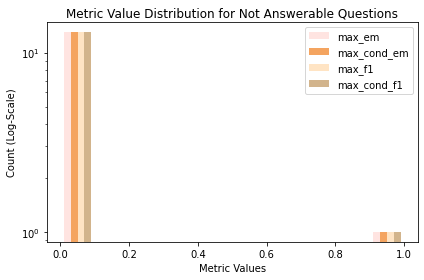

In [10]:
plt.figure()
METRICS = [f"max_{v}{u}" for u in ('em', 'f1') for v in ('', 'cond_')]
xs = [dfcb[dfcb['not_answerable']][m] for m in METRICS]
plt.hist(xs, color=['mistyrose', 'sandybrown', 'bisque', 'tan'])
plt.legend(METRICS)
plt.title("Metric Value Distribution for Not Answerable Questions")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Metric Values')
plt.tight_layout()
plt.savefig(f"{root_dir}/notans_metrics.png", dpi=128)

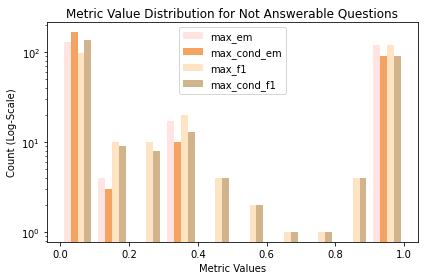

In [11]:
# take out answerable questions
answerables = dfcb[dfcb['not_answerable'] == False]

plt.figure()
METRICS = [f"max_{v}{u}" for u in ('em', 'f1') for v in ('', 'cond_')]
xs = [answerables[m] for m in METRICS]
plt.hist(xs, color=['mistyrose', 'sandybrown', 'bisque', 'tan'])
plt.legend(METRICS)
plt.title("Metric Value Distribution for Not Answerable Questions")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Metric Values')
plt.tight_layout()
plt.savefig(f"{root_dir}/ans_metrics.png", dpi=128)

### Yes/No vs. Extractive

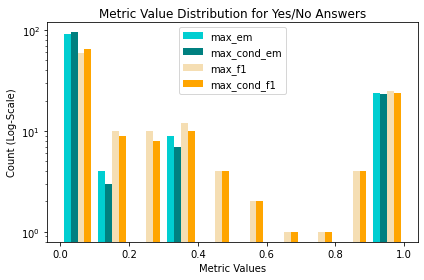

In [12]:
plt.figure()
METRICS = [f"max_{v}{u}" for u in ('em', 'f1') for v in ('', 'cond_')]
xs = [answerables[answerables['not_yesno']][m] for m in METRICS]
plt.hist(xs, color=['darkturquoise', 'teal', 'wheat', 'orange'])
plt.legend(METRICS)
plt.title("Metric Value Distribution for Yes/No Answers")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Metric Values')
plt.tight_layout()
plt.savefig(f"{root_dir}/yesno_metrics.png", dpi=128)

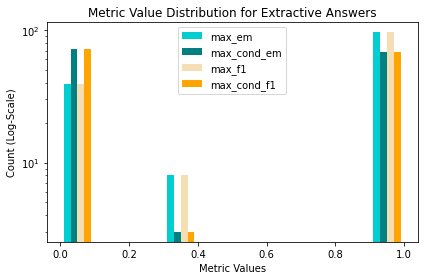

In [13]:
plt.figure()
METRICS = [f"max_{v}{u}" for u in ('em', 'f1') for v in ('', 'cond_')]
xs = [answerables[answerables['not_yesno'] == False][m] for m in METRICS]
plt.hist(xs, color=['darkturquoise', 'teal', 'wheat', 'orange'])
plt.legend(METRICS)
plt.title("Metric Value Distribution for Extractive Answers")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Metric Values')
plt.tight_layout()
plt.savefig(f"{root_dir}/extractive_metrics.png", dpi=128)

### Single Answer vs. Multiple Answers

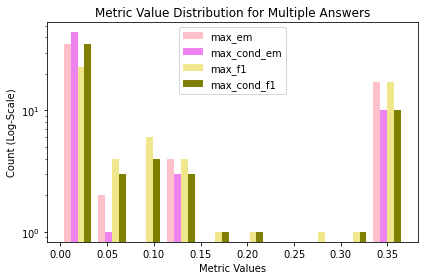

In [14]:
plt.figure()
METRICS = [f"max_{v}{u}" for u in ('em', 'f1') for v in ('', 'cond_')]
xs = [answerables[answerables['multi_ans']][m] for m in METRICS]
plt.hist(xs, color=['pink', 'violet', 'khaki', 'olive'])
plt.legend(METRICS)
plt.title("Metric Value Distribution for Multiple Answers")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Metric Values')
plt.tight_layout()
plt.savefig(f"{root_dir}/multians_metrics.png", dpi=128)

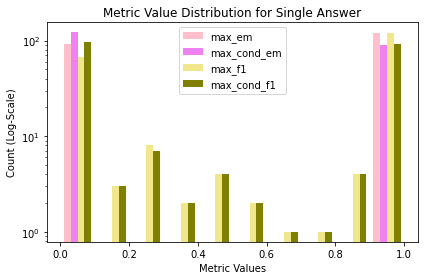

In [15]:
plt.figure()
METRICS = [f"max_{v}{u}" for u in ('em', 'f1') for v in ('', 'cond_')]
xs = [answerables[answerables['multi_ans'] == False][m] for m in METRICS]
plt.hist(xs, color=['pink', 'violet', 'khaki', 'olive'])
plt.legend(METRICS)
plt.title("Metric Value Distribution for Single Answer")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Metric Values')
plt.tight_layout()
plt.savefig(f"{root_dir}/unians_metrics.png", dpi=128)

### Answer Counts

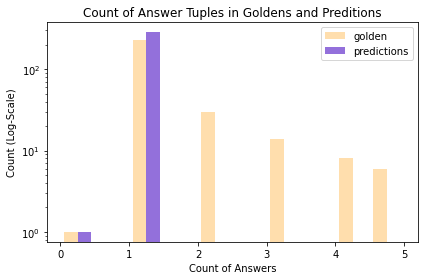

In [16]:
plt.figure()
xs = [dfcb['ans_cnt'], dfcb['pred_ans_cnt']]
plt.hist(xs, color=['navajowhite', 'mediumpurple'])
plt.legend(['golden', 'predictions'])
plt.title("Count of Answer Tuples in Goldens and Preditions")
plt.ylabel('Count (Log-Scale)')
plt.yscale('log')
plt.xlabel('Count of Answers')
plt.tight_layout()
plt.savefig(f"{root_dir}/ans_cnts.png", dpi=128)

## Not Answerable Questions 

Only 14 not answerable questions in total: list them all.

In [17]:
# not answerable questions
not_ans = dfcb[dfcb['not_answerable']]
print(f"A total of [{len(not_ans)}/{total_count}] not-answerable questions.")
not_ans.head(15)

A total of [14/285] not-answerable questions.


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-7,https://www.gov.uk/financial-help-disabled,I was injured in an accident at work 6 months ...,What is the maximum amount of Disability Livin...,True,[],[],dev-7,[],1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,0,0
dev-29,https://www.gov.uk/maternity-pay-leave,I'm a 35 years old woman with Chinese passport...,If I have a baby will I keep my visa even if I...,True,"[(, [])]",[],dev-29,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-31,https://www.gov.uk/child-adoption,I am a 25 year old who has recently married. M...,Can I apply to adopt Ariana now that we are ma...,True,"[(, [])]",[],dev-31,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-34,https://www.gov.uk/renounce-british-nationality,"I was born in 1999 in London, I grow up there ...",Japan doesn't allow dual citizenship and I wan...,True,"[(, [])]",[],dev-34,"[[6 months, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-89,https://www.gov.uk/pay-psa,I got my nationality 2 years before and I try ...,How many years nationality do I need to get be...,True,"[(, [])]",[],dev-89,"[[2 years, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-116,https://www.gov.uk/debt-payments-from-your-wages,I defaulted on payments on a store card that I...,Taking money from my wages will leave me unabl...,True,"[(, [])]",[],dev-116,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-118,https://www.gov.uk/tax-on-shopping,I live in Northern Ireland. I met my cousin wh...,Can I claim the VAT back at the airport on her...,True,"[(, [])]",[],dev-118,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-152,https://www.gov.uk/taking-vehicles-out-of-uk,I am a German citizen who has been living in t...,Is it easier for me to sell my car in the UK a...,True,"[(, [])]",[],dev-152,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-157,https://www.gov.uk/electoral-register,Me and my family recently moved from Mancheste...,Do we have to update the details on our electo...,True,"[(, [])]",[],dev-157,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-199,https://www.gov.uk/claiming-money-or-property-...,My small company has suffered badly as a resul...,Is there any sort of grant that we can apply f...,True,"[(, [])]",[],dev-199,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1


## Successful Examples

#### 1. Successful Exact Match

In [18]:
# yesno questions
yesno = answerables[answerables['not_yesno'] == False]
yesno_perfect_em = yesno[yesno['perfect_em']]
yesno_perfect_condem = yesno[yesno['perfect_condem']]
print(f"A total of [{len(yesno)}/{total_count}] yes/no questions, "
      f"[{len(yesno_perfect_em)}/{len(yesno)}] perfect EM, "
      f"[{len(yesno_perfect_condem)}/{len(yesno_perfect_em)}] perfect Cond EM. ")
yesno_perfect_condem.head(5)

A total of [143/285] yes/no questions, [96/143] perfect EM, [68/96] perfect Cond EM. 


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-4,https://www.gov.uk/tax-property-money-shares-y...,I recently inherited my childhood home in Suss...,Will I pay capital gains tax if I sell my curr...,False,"[[no, []]]",[<p>You don’t pay Capital Gains Tax when you s...,dev-4,"[[no, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-5,https://www.gov.uk/parental-bereavement-pay-leave,I work for a large company as an employee and ...,Can my partner take leave from work due to my ...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-5,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-6,https://www.gov.uk/parental-bereavement-pay-leave,My husband and I were in the process of adopti...,Are adoptive parents entitled to bereavement l...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-6,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-13,https://www.gov.uk/housing-benefit,"I'm 71, and am currently living in rented acco...",Can I continue to claim Housing Benefit?,False,"[[yes, []]]",[<p>Your existing claim will not be affected i...,dev-13,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-27,https://www.gov.uk/housing-benefit,The whole of 2020 and 2021 i went through a ve...,The council have now found me some temporary h...,False,"[[yes, []]]",[<p>You can only make a new claim for Housing ...,dev-27,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1


In [19]:
# not-yesno questions
non_yesno = answerables[answerables['not_yesno']]
non_yesno_perfect_em = non_yesno[non_yesno['perfect_em']]
non_yesno_perfect_condem = non_yesno[non_yesno['perfect_condem']]
print(f"A total of [{len(non_yesno)}/{total_count}] yes/no questions, "
      f"[{len(non_yesno_perfect_em)}/{len(non_yesno)}] perfect EM, "
      f"[{len(non_yesno_perfect_condem)}/{len(non_yesno_perfect_em)}] perfect Cond EM. ")
non_yesno_perfect_condem.head(5)

A total of [128/285] yes/no questions, [24/128] perfect EM, [23/24] perfect Cond EM. 


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-23,https://www.gov.uk/court-funds-office-processes,My friend was sadly involved in an accident at...,What interest rate is paid on a Court Funds Of...,False,"[[0.1%, []]]",[<p>A Court Funds Office account is called a ‘...,dev-23,"[[0.1%, []]]",1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,1,1
dev-51,https://www.gov.uk/register-land-rural-land-re...,My Aunt lives in scotland and has inherited th...,Whom can she contact to get advise?,False,"[[the rural payments agency, []]]",[<p>The Rural Land Register only covers land i...,dev-51,"[[the rural payments agency, []]]",1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,1,1
dev-52,https://www.gov.uk/renounce-british-nationality,My brother relocated abroad to live with his w...,How much fee will he pay to get biometric info...,False,"[[£19.20, []]]",[<p>You’ll also need to pay £19.20 to have you...,dev-52,"[[£19.20, []]]",1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,1,1
dev-77,https://www.gov.uk/driving-instructor-suspensi...,I have recently been arrested on suspicion of ...,What will happen if I am convicted?,False,[[your approved driving instructor (adi) regis...,[<p>Your approved driving instructor (ADI) reg...,dev-77,[[your approved driving instructor (adi) regis...,1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,1,1
dev-87,https://www.gov.uk/pay-psa,I am an employer who operates payroll. I have ...,Where do I setup a direct debit?,False,[[through your business’s hm revenue and custo...,[<p>Set up a Direct Debit through your busines...,dev-87,[[through your business’s hm revenue and custo...,1.0,1.0,...,True,True,True,True,False,True,0.0,0.0,1,1


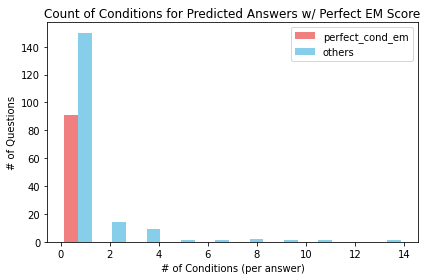

In [20]:
# plot the count of conditions for perfect answers
plt.figure()
xs = [
    answerables[answerables['perfect_condem']]['cond_cnt'], 
    answerables[answerables['perfect_condem'] == False]['cond_cnt']
]
plt.hist(xs, color=['lightcoral', 'skyblue'])
plt.title('Count of Conditions for Predicted Answers w/ Perfect EM Score')
plt.xlabel('# of Conditions (per answer)')
plt.ylabel('# of Questions')
plt.legend(['perfect_cond_em', 'others'])
plt.tight_layout()
plt.savefig(f"{root_dir}/perfect_condem_cond_cnts.png", dpi=128)

#### 2. Perfect F1 Score

In [21]:
# yesno questions
yesno_perfect_f1 = yesno[yesno['perfect_f1']]
yesno_perfect_condf1 = yesno[yesno['perfect_condf1']]
print(f"A total of [{len(yesno)}/{total_count}] yes/no questions, "
      f"[{len(yesno_perfect_f1)}/{len(yesno)}] perfect F1, "
      f"[{len(yesno_perfect_condf1)}/{len(yesno_perfect_f1)}] perfect Cond F1. ")

yesno_perfect_condf1.head(5)

A total of [143/285] yes/no questions, [96/143] perfect F1, [68/96] perfect Cond F1. 


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-4,https://www.gov.uk/tax-property-money-shares-y...,I recently inherited my childhood home in Suss...,Will I pay capital gains tax if I sell my curr...,False,"[[no, []]]",[<p>You don’t pay Capital Gains Tax when you s...,dev-4,"[[no, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-5,https://www.gov.uk/parental-bereavement-pay-leave,I work for a large company as an employee and ...,Can my partner take leave from work due to my ...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-5,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-6,https://www.gov.uk/parental-bereavement-pay-leave,My husband and I were in the process of adopti...,Are adoptive parents entitled to bereavement l...,False,"[[yes, []]]",[<p>You and your partner may be able to take t...,dev-6,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-13,https://www.gov.uk/housing-benefit,"I'm 71, and am currently living in rented acco...",Can I continue to claim Housing Benefit?,False,"[[yes, []]]",[<p>Your existing claim will not be affected i...,dev-13,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1
dev-27,https://www.gov.uk/housing-benefit,The whole of 2020 and 2021 i went through a ve...,The council have now found me some temporary h...,False,"[[yes, []]]",[<p>You can only make a new claim for Housing ...,dev-27,"[[yes, []]]",1.0,1.0,...,True,True,True,True,False,False,0.0,0.0,1,1


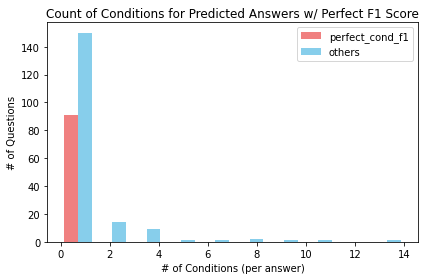

In [22]:
# plot the count of conditions for perfect answers
plt.figure()
xs = [
    answerables[answerables['perfect_condf1']]['cond_cnt'], 
    answerables[answerables['perfect_condf1'] == False]['cond_cnt']
]
plt.hist(xs, color=['lightcoral', 'skyblue'])
plt.title('Count of Conditions for Predicted Answers w/ Perfect F1 Score')
plt.xlabel('# of Conditions (per answer)')
plt.ylabel('# of Questions')
plt.legend(['perfect_cond_f1', 'others'])
plt.tight_layout()
plt.savefig(f"{root_dir}/perfect_condf1_cond_cnts.png", dpi=128)


### Confusion Matrix for Yes/No Questions

In [23]:
from sklearn.metrics import confusion_matrix
from tabulate import tabulate

def get_confusion(col1, col2):
    refs = {'yes', 'no', 'NA'}
    # taken out simply yes / no
    gold_list = col1.tolist()
    pred_list = col2.tolist()
    full_golds = list()
    full_preds = list()
    for i, gold in enumerate(gold_list):
        pred = pred_list[i]
        C = max(len(pred), len(gold))
        for j in range(C):
            p = pred[j][0] if j < len(pred) else 'NA'
            g = gold[j][0] if j < len(gold) else 'NA'
            # correct the labels
            p = p if p in refs else 'extractive'
            g = g if g in refs else 'extractive'
            full_golds.append(g)
            full_preds.append(p)
    cm = confusion_matrix(
        full_golds, full_preds, labels=['yes', 'no', 'extractive', 'NA']
    ) 
    return cm, cm / cm.sum()

test = answerables.copy()
get_confusion(test['answers'], test['answers_pred'])

/opt/homebrew/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


(array([[ 92,   6,   0,   2],
        [ 35,  10,   0,   6],
        [ 10,   3, 115,  98],
        [  0,   0,   0,   0]]),
 array([[0.24403183, 0.01591512, 0.        , 0.00530504],
        [0.0928382 , 0.0265252 , 0.        , 0.01591512],
        [0.0265252 , 0.00795756, 0.30503979, 0.25994695],
        [0.        , 0.        , 0.        , 0.        ]]))

## Temporary Failures

### Missing Conditions in Prediction

In [24]:
f"A total of [{len(answerables[answerables['pred_cond_cnt'] != 0])}] predictions ended up w/ conditions."

'A total of [0] predictions ended up w/ conditions.'

*...absolutely stunning*

### More or Fewer Answers

In [25]:
# more answers than expected
answerables[answerables['ans_cnt'] < answerables['pred_ans_cnt']]

,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt


In [26]:
# fewer answers than expected
predicted_fewer = answerables[answerables['ans_cnt'] > answerables['pred_ans_cnt']]
print(f"A total of [{len(predicted_fewer)}/{len(answerables)}] answerable questions got fewer answers.")
predicted_fewer.head(10)

A total of [58/271] answerable questions got fewer answers.


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-9,https://www.gov.uk/tax-property-money-shares-y...,I inherited forty thousand pounds from my late...,Do I have to pay inheritance tax on my windfall?,False,"[[yes, [<p>The estate of the person who died u...",[<p>You don’t usually pay tax on anything you ...,dev-9,"[[yes, []]]",0.367879,0.0,...,False,False,False,False,True,False,1.00,0.0,2,1
dev-12,https://www.gov.uk/support-for-foster-parents,I have completed a training to be an approved ...,What are my tax liability of the money I recei...,False,"[[in a tax year, households do not pay tax on ...","[<p>In your tax return, you’ll be able to clai...",dev-12,"[[up to £10,000 per household, []]]",0.0,0.0,...,False,False,False,False,True,True,1.00,0.0,2,1
dev-25,https://www.gov.uk/financial-help-disabled,I'm 63 and I had a car accident 1 year ago whi...,"My wife died 2 years ago, what kind of support...",False,"[[personal independence payment (pip), []], [e...","[<p>Some benefits you might get are:</p>, <li>...",dev-25,[[help with the extra costs caused by long ter...,0.0,0.0,...,False,False,False,False,True,True,0.25,0.0,4,1
dev-36,https://www.gov.uk/children-with-special-educa...,My child has recently diagnosed with dyslexia ...,Is there any funding or support available for ...,False,"[[sen support, []], [an education, health and ...",[<p>If you think your child may have special e...,dev-36,"[[yes, []]]",0.0,0.0,...,False,False,False,False,True,True,0.00,0.0,2,1
dev-38,https://www.gov.uk/claim-gift-aid,"I run a small, independent charity which attem...",Am I eligible for Gift Aid?,False,"[[yes, [<p>You must be recognised as a charity...",[<p>You can claim back 25p every time an indiv...,dev-38,"[[yes, []]]",0.367879,0.0,...,False,False,False,False,True,False,4.00,0.0,2,1
dev-43,https://www.gov.uk/honours,I recently met a widow who told me that her hu...,What are the requirements to be honored as Off...,False,"[[made achievements in public life, []], [comm...",[<p>The honours system recognises people who h...,dev-43,"[[having a major local role in any activity, []]]",0.0,0.0,...,False,False,False,False,True,True,0.00,0.0,3,1
dev-54,https://www.gov.uk/volunteer-as-a-coastguard,My husband is very interested in sailing in de...,What training is required to be a coastguard v...,False,"[[initial training by hm coastguard, []], [reg...",[<p>You must pass initial training by HM Coast...,dev-54,"[[search techniques, []]]",0.0,0.0,...,False,False,False,False,True,True,0.00,0.0,2,1
dev-56,https://www.gov.uk/children-with-special-educa...,I am a mother to an adopted 14 years old son. ...,What help can I get about these special concer...,False,"[[a special learning programme, []], [extra he...",[<p>If you think your child may have special e...,dev-56,[[a child health visitor carrying out a health...,0.0,0.0,...,False,False,False,False,True,True,0.00,0.0,5,1
dev-67,https://www.gov.uk/masters-loan,I am looking at doing master's course in the U...,How much funding is available for a postgradua...,False,"[[£11,570, [<li>£11,570 if your course starts ...","[<p>You can get up to:</p>, <li>£11,570 if you...",dev-67,"[[£11,222, []]]",0.135335,0.0,...,False,False,False,False,True,True,1.00,0.0,3,1
dev-73,https://www.gov.uk/motorcycle-cbt,I have signed up for the CBT training course t...,What should I bring for the CBT lessons?,False,"[[uk driving licence, []], [a motorcycle helme...",[<p>Take your UK driving licence to your train...,dev-73,"[[your own moped or motorcycle, []]]",0.0,0.0,...,False,False,False,False,True,True,0.00,0.0,5,1


### Inverse Answer to Yes/No Problems

In [27]:
def disagree(x):
    return x['answers'][0][0] != x['answers_pred'][0][0]

yesno_disagree = yesno[yesno.apply(disagree, axis=1)]
print(f"There are a total of [{len(yesno_disagree)}/{len(yesno)}] yes/no answers w/ opposite opinions.")
yesno_disagree.head(5)

There are a total of [41/143] yes/no answers w/ opposite opinions.


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-17,https://www.gov.uk/support-for-foster-parents,My partner and i are foster parents to our lov...,Will we be eligible for a paid leave from wor...,False,"[[no, []]]",[<p>You do not have a statutory right to time ...,dev-17,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,1,1
dev-19,https://www.gov.uk/housing-benefit,"I am 24, single and currently working only par...",Would I be entitled to claim Housing Benefit?,False,"[[no, []]]",[<p>You can only make a new claim for Housing ...,dev-19,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,1,1
dev-20,https://www.gov.uk/apply-special-guardian,I am a 17 year old from Kent and my mother is ...,Can I apply to become my brothers legal guardi...,False,"[[no, []]]",[<p>You can apply to be a child’s special guar...,dev-20,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,1,1
dev-26,https://www.gov.uk/enduring-power-attorney-duties,My 83 year old mother who I care for is unable...,Can I overrule her decision and become her att...,False,"[[no, []]]",[<p>You can help make or make decisions about ...,dev-26,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,1,1
dev-32,https://www.gov.uk/register-land-rural-land-re...,I am a Farmer who has recently moved to the UK...,Do I need to register the land with the same o...,False,"[[no, []]]",[<p>Register with your local Rural Payments an...,dev-32,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,False,0.0,0.0,1,1


#### Yes/No Ratio Distribution

(Counter({'yes': 98, 'no': 45}), Counter({'yes': 127, 'no': 16}))

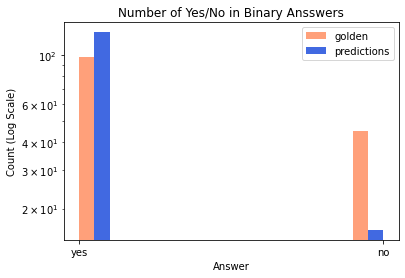

In [28]:
from collections import Counter

gold_yesnos = [u[0][0] for u in yesno['answers'].tolist()]
pred_yesnos = [u[0][0] for u in yesno['answers_pred'].tolist()]

plt.figure()
plt.hist(
    [gold_yesnos, pred_yesnos], 
    color=['lightsalmon', 'royalblue'],
    rwidth=5
)
plt.legend(['golden', 'predictions'])
plt.title('Number of Yes/No in Binary Ansswers')
plt.xlabel('Answer')
plt.ylabel('Count (Log Scale)')
plt.yscale('log')
plt.savefig(f"{root_dir}/yesno_cnts.png", dpi=128)

Counter(gold_yesnos), Counter(pred_yesnos)

### Wrong Extraction

In [29]:
non_yesno_disagree = non_yesno[non_yesno.apply(disagree, axis=1)]
print(f"There are a total of [{len(non_yesno_disagree)}/{len(non_yesno)}] extraction answers that are incorrect.")
non_yesno_disagree.head(5)

There are a total of [97/128] extraction answers that are incorrect.


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-0,https://www.gov.uk/apply-special-guardian,My brother and his wife are in prison for carr...,How long will it be before I hear back from th...,False,"[[within 10 days, []]]",[<p>Within 10 days of receiving your applicati...,dev-0,"[[until they’re 18, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-1,https://www.gov.uk/child-adoption,Me and my partner have been trying for a child...,Are there any age requirements for the adopter...,False,"[[aged 21 or over, []]]",[<p>You may be able to adopt a child if you’re...,dev-1,"[[no, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-10,https://www.gov.uk/attendance-allowance,I suffer from severe arthritis which means tha...,What level of Attendance Allowance can I claim...,False,"[[lower rate - £60, []]]",[<p>You could get £60 or £89.60 a week to help...,dev-10,"[[£60 or £89.60 a week, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-11,https://www.gov.uk/child-adoption,Me and my partner recently adopted a child. It...,To pay for the counselling or therapy for the ...,False,"[[adoption support fund, []]]",[<p>You may be able to get funding from the Ad...,dev-11,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-12,https://www.gov.uk/support-for-foster-parents,I have completed a training to be an approved ...,What are my tax liability of the money I recei...,False,"[[in a tax year, households do not pay tax on ...","[<p>In your tax return, you’ll be able to clai...",dev-12,"[[up to £10,000 per household, []]]",0.0,0.0,...,False,False,False,False,True,True,1.0,0.0,2,1


However, there are extraction problems that look like a yes/no problem in the way it's asked.

In [30]:
non_yesno_disagree_pred_yesno = non_yesno_disagree[non_yesno_disagree['answers_pred'].apply(non_yesno_answer) == False]
print(f"There are a total of [{len(non_yesno_disagree_pred_yesno)}/{len(non_yesno_disagree)}] extraction answers that are taken as yes/no.")
non_yesno_disagree_pred_yesno.head(10)

There are a total of [13/97] extraction answers that are taken as yes/no.


,url,scenario,question,not_answerable,answers,evidences,id,answers_pred,max_em,max_cond_em,...,perfect_f1,perfect_condf1,high_f1,high_condf1,multi_ans,not_yesno,cond_cnt,pred_cond_cnt,ans_cnt,pred_ans_cnt
dev-1,https://www.gov.uk/child-adoption,Me and my partner have been trying for a child...,Are there any age requirements for the adopter...,False,"[[aged 21 or over, []]]",[<p>You may be able to adopt a child if you’re...,dev-1,"[[no, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-11,https://www.gov.uk/child-adoption,Me and my partner recently adopted a child. It...,To pay for the counselling or therapy for the ...,False,"[[adoption support fund, []]]",[<p>You may be able to get funding from the Ad...,dev-11,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-30,https://www.gov.uk/support-for-foster-parents,I have been fostering a 10-year old girl for s...,Am I able to sign the consent form for my fost...,False,[[check your child placement plan to find out ...,[<p>Your foster child’s placement plan should ...,dev-30,"[[no, []]]",0.0,0.0,...,False,False,False,False,False,True,1.0,0.0,1,1
dev-36,https://www.gov.uk/children-with-special-educa...,My child has recently diagnosed with dyslexia ...,Is there any funding or support available for ...,False,"[[sen support, []], [an education, health and ...",[<p>If you think your child may have special e...,dev-36,"[[yes, []]]",0.0,0.0,...,False,False,False,False,True,True,0.0,0.0,2,1
dev-98,https://www.gov.uk/running-payroll,I am about to give out the first payslips to m...,Is there anything else that I need to include?,False,"[[pay after deductions, []], [the number of ho...","[<p>Payslips must show:</p>, <li>pay before an...",dev-98,"[[yes, []]]",0.0,0.0,...,False,False,False,False,True,True,0.5,0.0,2,1
dev-154,https://www.gov.uk/appeal-qualification-result,I am eighteen and have just received my A leve...,Can I challenge my A level results and if so how?,False,[[ask your school or college to get an exam re...,"[<p>You can challenge the result of a GCSE, AS...",dev-154,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,1.0,0.0,1,1
dev-155,https://www.gov.uk/appeal-qualification-result,I asked for a review of my GCSE results after ...,Can I appeal against the results of the review?,False,"[[ask the exams officer, headteacher or princi...",[<p>If you asked for an exam result to be revi...,dev-155,"[[yes, []]]",0.0,0.0,...,False,False,False,False,True,True,0.5,0.0,2,1
dev-182,https://www.gov.uk/change-circumstances-visa-brp,I am a Latvian national and am currently in th...,"Will I need a new BRP, or can I simply update ...",False,"[[report a change of address online, []]]",[<p>You can change your address without having...,dev-182,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-183,https://www.gov.uk/change-circumstances-visa-brp,"I am a Spanish national, and currently reside ...",Can I update the details of my present applica...,False,[[you may need to make another visa applicatio...,[<p>How you report a change of circumstances d...,dev-183,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
dev-203,https://www.gov.uk/pay-corporation-tax,I started a limited company 13 months back. M...,I want to know whether HMRC has received my Co...,False,[[check your hm revenue and customs (hmrc) onl...,[<p>Check your HM Revenue and Customs (HMRC) o...,dev-203,"[[yes, []]]",0.0,0.0,...,False,False,False,False,False,True,0.0,0.0,1,1
